In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sheroook","key":"02840f90001498510610d93321c345e1"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
cd /content

/content


In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 93% 81.0M/86.8M [00:02<00:00, 26.3MB/s]
100% 86.8M/86.8M [00:02<00:00, 34.1MB/s]


In [ ]:
from zipfile import ZipFile

file_name = "/content/brain-tumor-classification-mri.zip"

# opening the zip file in read me mode
with ZipFile(file_name, 'r') as zip :
  print("Extracting the files...")
  zip.extractall()
  print("Done")

Extracting the files...
Done


In [ ]:
import glob
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# hyperparameter setting
image_size = 224
batch_size = 32

In [ ]:
import os
c=0
for i in os.listdir('/content/brain-tumor-classification-mri/Training/no_tumor'):
  c+=1
print(c)

395


In [ ]:
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_yen
from skimage.io import imread, imsave
from google.colab.patches import cv2_imshow
import cv2
import imutils
#Apply AUG for NORMAL class only
c=0
for IM in os.listdir('/content/brain-tumor-classification-mri/Training/no_tumor/'):
  img = cv2.imread("/content/brain-tumor-classification-mri/Training/no_tumor/"+IM)
  if c%2==0: #using different 2 aug. based on index
    #pass
    # Use Flip code 1 to flip horizontally 
    img = cv2.flip(img, 1) 
    alpha = 1 # Contrast control (1.0-3.0)
    beta = 20 # Brightness control (0-100)
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    #cv2_imshow(img)
    imsave("/content/brain-tumor-classification-mri/Training/no_tumor/"+IM+'Aug1.jpeg', img)
  else:
    img = imutils.rotate(img, 20)
    alpha = 1 # Contrast control (1.0-3.0)
    beta = 20 # Brightness control (0-100)
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    imsave("/content/brain-tumor-classification-mri/Training/no_tumor/"+IM+'Aug2.jpeg', img)
  print(IM)
  print(c)
  c+=1

image(287).jpg
0
image(239).jpg
1
image(43).jpg
2
image (57).jpg
3
image(7).jpg
4
image(159).jpg
5
image(190).jpg
6
image(288).jpg
7
image(229).jpg
8
image(187).jpg
9
image(59).jpg
10
image(234).jpg
11
image(9).jpg
12
image(325).jpg
13
image(46).jpg
14
image(129).jpg
15
image(160).jpg
16
image(246).jpg
17
image(219).jpg
18
image(212).jpg
19
image(308).jpg
20
image(115).jpg
21
image(145).jpg
22
image (55).jpg
23
image(263).jpg
24
image(61).jpg
25
image(81).jpg
26
image(117).jpg
27
image (21).jpg
28
image (36).jpg
29
image(126).jpg
30
image(34).jpg
31
image(313).jpg
32
image(172).jpg
33
image(280).jpg
34
image (56).jpg
35
image (33).jpg
36
image(23).jpg
37
image (43).jpg
38
image(204).jpg
39
image(84).jpg
40
image(320).jpg
41
image(12).jpg
42
image(210).jpg
43
image(78).jpg
44
image(51).jpg
45
image (45).jpg
46
image(136).jpg
47
image(39).jpg
48
image(284).jpg
49
image(192).jpg
50
image(119).jpg
51
image (16).jpg
52
image(156).jpg
53
image(221).jpg
54
image(157).jpg
55
image(154).jpg
56


In [ ]:
# input files
base_dir="/content/drive/MyDrive/brain-tumor-classification-mri"

glioma_tumor = glob.glob(base_dir + '/**/glioma_tumor/*')
meningioma_tumor = glob.glob(base_dir + '/**/meningioma_tumor/*')
pituitary_tumor = glob.glob(base_dir + '/**/pituitary_tumor/*')
normal = glob.glob(base_dir + '/**/no_tumor/*')

print("glioma_tumor : {}".format(len(glioma_tumor)))
print("meningioma_tumor : {}".format(len(meningioma_tumor)))
print("pituitary_tumor : {}".format(len(pituitary_tumor)))
print("normal : {}".format(len(normal)))

glioma_tumor : 926
meningioma_tumor : 937
pituitary_tumor : 901
normal : 895


In [ ]:
# add labels
def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

glioma_tumor = add_labels(glioma_tumor, 'glioma')
meningioma_tumor = add_labels(meningioma_tumor, 'meningioma')
pituitary_tumor = add_labels(pituitary_tumor, 'pituitary')
normal = add_labels(normal, 'normal')

print(glioma_tumor[0])
print(meningioma_tumor[0])
print(pituitary_tumor[0])
print(normal[0])

('/content/drive/MyDrive/brain-tumor-classification-mri/Testing/glioma_tumor/image(66).jpg', 'glioma')
('/content/drive/MyDrive/brain-tumor-classification-mri/Testing/meningioma_tumor/image(42).jpg', 'meningioma')
('/content/drive/MyDrive/brain-tumor-classification-mri/Testing/pituitary_tumor/image(10).jpg', 'pituitary')
('/content/drive/MyDrive/brain-tumor-classification-mri/Testing/no_tumor/image(98).jpg', 'normal')


In [ ]:
# split the data
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.15)
    train_data, val_data = train_test_split(train_data, test_size=0.15)
    return [train_data, val_data, test_data]

glioma_data = split_data(glioma_tumor)
meningioma_data = split_data(meningioma_tumor)
pituitary_data = split_data(pituitary_tumor)
normal_data = split_data(normal)

In [ ]:
# collect data
train_data = []
val_data = []
test_data = []

def collect(data):
    global train_data, val_data, test_data
    for sample in data[0]:
        train_data.append(sample)
    
    for sample in data[1]:
        val_data.append(sample)
        
    for sample in data[2]:
        test_data.append(sample)

collect(glioma_data)
collect(meningioma_data)
collect(pituitary_data)
collect(normal_data)
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

2640 468 551


In [ ]:
# data augmentation (train)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=10,
                               zoom_range = 0.1,
                               shear_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True)

train_set = train_gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='image',
                                          y_col='label',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          shuffle=True,
                                          class_mode='categorical',
                                          color_mode='rgb' )

# rescaling (validation)
val_rescaled = ImageDataGenerator(rescale = 1./255)

val_set = val_rescaled.flow_from_dataframe(dataframe=val_df,
                                           x_col='image',
                                           y_col='label',
                                           target_size=(image_size, image_size),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           class_mode='categorical',
                                           color_mode='rgb')

# rescaling (test)
test_rescaled = ImageDataGenerator(rescale = 1./255)

test_set = test_rescaled.flow_from_dataframe(dataframe=test_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='rgb')

Found 2640 validated image filenames belonging to 4 classes.
Found 468 validated image filenames belonging to 4 classes.
Found 551 validated image filenames belonging to 4 classes.


In [ ]:
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.applications import VGG19
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras.models import Model, Sequential
import matplotlib.pyplot as plt
from keras.layers import Input
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from tensorflow.python.keras import regularizers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [ ]:

input_tensor = Input(shape=(224, 224, 3))
vgg_conv = VGG19(weights='imagenet',
                               include_top=False,
                               input_tensor=input_tensor)
# Freeze the layers except the last 2 layers
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()
# Add the vgg convolutional base model
model.add(vgg_conv)
model.add(layers.Dropout(0.5))
model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
model.add(SeparableConv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(SeparableConv2D(64, (5,5), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


80142336/80134624 [==============================] - 1s 0us/step
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f389306fe10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3896fd83d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3896b5d810> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f389063ad10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f389063b590> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f38927a5c50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f38927a5350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f389063b2d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3890647f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3890653a10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f389063add0> Fals

In [ ]:
# model configuration
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=8, 
                   restore_best_weights=True)

# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                  patience = 4, 
#                                  verbose=1,
#                                  factor=0.5, 
#                                  min_lr=0.00005)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 7, 7, 128)         70272     
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 7, 7, 128)         17664     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 128)         0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 3, 3, 64)          11456     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0

In [ ]:
history = model.fit_generator(train_set,
                              steps_per_epoch=len(train_set),
                              epochs=15,
                              validation_data=val_set,
                              validation_steps=len(val_set),
                              callbacks=[es]) 

Epoch 1/15
83/83 [==============================] - 104s 767ms/step - loss: 1.3667 - accuracy: 0.2862 - val_loss: 1.0605 - val_accuracy: 0.5214
Epoch 2/15
83/83 [==============================] - 51s 612ms/step - loss: 1.0251 - accuracy: 0.5265 - val_loss: 0.8079 - val_accuracy: 0.6645
Epoch 3/15
83/83 [==============================] - 51s 612ms/step - loss: 0.8766 - accuracy: 0.6032 - val_loss: 0.7547 - val_accuracy: 0.6944
Epoch 4/15
83/83 [==============================] - 51s 617ms/step - loss: 0.7027 - accuracy: 0.6884 - val_loss: 0.6910 - val_accuracy: 0.7115
Epoch 5/15
83/83 [==============================] - 51s 612ms/step - loss: 0.6191 - accuracy: 0.7321 - val_loss: 0.5876 - val_accuracy: 0.7927
Epoch 6/15
83/83 [==============================] - 51s 616ms/step - loss: 0.5285 - accuracy: 0.7897 - val_loss: 0.4509 - val_accuracy: 0.8269
Epoch 7/15
83/83 [==============================] - 51s 613ms/step - loss: 0.4130 - accuracy: 0.8384 - val_loss: 0.4751 - val_accuracy: 0.816

In [ ]:
model.save('BrainTumorClassification.h5')

In [ ]:
model.save_weights('BrainTumorWeights.h5')

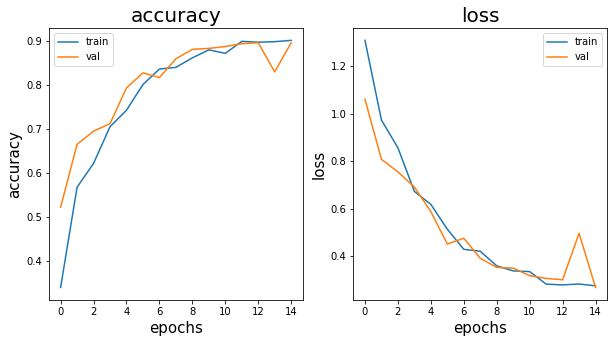

In [ ]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].plot(history.history['val_' + e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

In [ ]:
from tensorflow import keras
model= keras.models.load_model('/content/drive/MyDrive/brainTumorClassification/BrainTumorClassification.h5')

In [ ]:
# test the model
predictions = model.predict_classes(test_set)

cm = confusion_matrix(test_set.classes, predictions)

<Figure size 432x288 with 0 Axes>

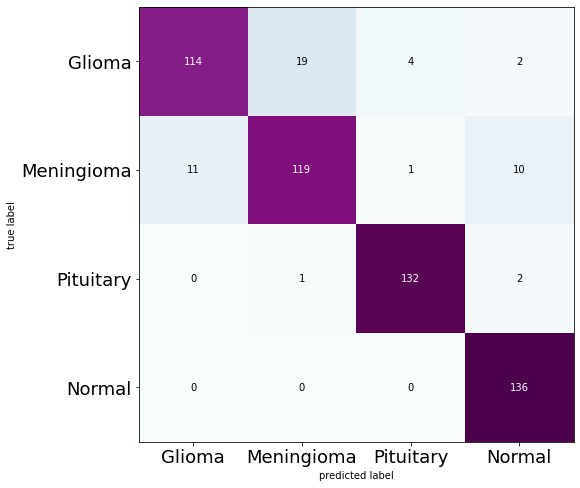

In [ ]:
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.BuPu)
plt.xticks(range(4), ['Glioma','Meningioma','Pituitary', 'Normal'], fontsize=18)
plt.yticks(range(4), ['Glioma','Meningioma','Pituitary', 'Normal'], fontsize=18)
plt.show()

In [ ]:
test_accuracy = (cm[0, 0] + cm[1, 1] + cm[2,2] + cm[3,3]) / len(test_set)
print("Test Accuracy: {}%".format(round(test_accuracy * 100, 3)))

Test Accuracy: 90.926%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/brainTumorClassification/BrainTumorClassification.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/brainTumorClassification/BrainTumorWeights.h5')